In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

In [ ]:
words = open('names.txt', 'r').read().splitlines()

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [ ]:
block_size = 3

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
#initializing with kaiming initialization

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) #* 0.2
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

In [ ]:
torch.randn(1000).std()

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [ ]:
hpreact.shape

In [ ]:
hpreact.mean(0, keepdim=True).shape

In [ ]:
#Forward
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001 * bnstdi
        
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track LR stats:
    # lri.append(lre[i])
    if i % 10000 == 0:
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    
    
print(loss.item())

In [83]:
#4-dimensional example of the issue
# logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
logits = torch.randn(4)*10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

#fixing softmax from being confidently wrong at initialization
#large numbers at init can cause softmax function to predict the next character with probability very near 1 and the rest zero
#multiply weights by a small scale factor and start with zero bias to better initialize and spend less cycles squashing the parameters

(tensor([ -6.1218,  -0.6446,   5.4820, -13.9032]),
 tensor([9.1114e-06, 2.1792e-03, 9.9781e-01, 3.8033e-09]),
 tensor(0.0022))

In [84]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [85]:
# plt.plot(lossi)

(array([ 976.,  223.,  121.,  154.,  107.,   73.,   77.,   71.,   66.,
          57.,   52.,   65.,   57.,   67.,   76.,   68.,   75.,   68.,
          56.,   89.,  104.,   80.,  106.,  108.,  102.,  126.,  133.,
         100.,   71.,   75.,   71.,   72.,   99.,   50.,   55.,   55.,
          42.,   61.,   72.,   49.,   76.,   59.,   74.,   92.,  105.,
          88.,  122.,  195.,  271., 1089.]),
 array([-9.99999940e-01, -9.59999942e-01, -9.19999943e-01, -8.79999944e-01,
        -8.39999945e-01, -7.99999946e-01, -7.59999948e-01, -7.19999949e-01,
        -6.79999950e-01, -6.39999951e-01, -5.99999952e-01, -5.59999954e-01,
        -5.19999955e-01, -4.79999956e-01, -4.39999957e-01, -3.99999958e-01,
        -3.59999959e-01, -3.19999961e-01, -2.79999962e-01, -2.39999963e-01,
        -1.99999964e-01, -1.59999965e-01, -1.19999967e-01, -7.99999678e-02,
        -3.99999690e-02,  2.98023224e-08,  4.00000286e-02,  8.00000274e-02,
         1.20000026e-01,  1.60000025e-01,  2.00000024e-01,  2.400000

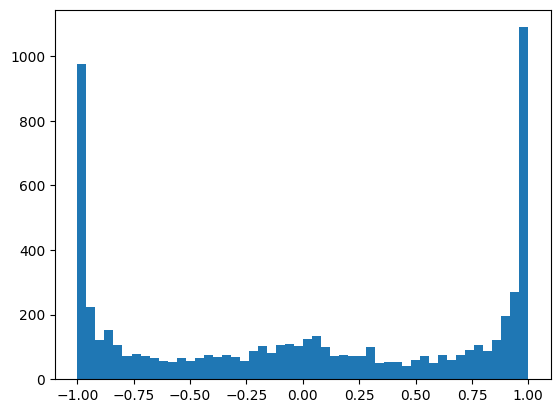

In [86]:
plt.hist(h.view(-1).tolist(), 50)

(array([  3.,   1.,   1.,   9.,   8.,   8.,  15.,  16.,  25.,  31.,  40.,
         43.,  78.,  86.,  95., 143., 163., 199., 233., 278., 315., 361.,
        666., 895., 469., 365., 306., 319., 251., 211., 154., 146., 123.,
         91.,  66.,  52.,  46.,  29.,  15.,  16.,  12.,   9.,   0.,   3.,
          3.,   1.,   0.,   0.,   0.,   1.]),
 array([-8.65104008, -8.27947334, -7.90790661, -7.53633987, -7.16477314,
        -6.79320641, -6.42163967, -6.05007294, -5.6785062 , -5.30693947,
        -4.93537273, -4.563806  , -4.19223927, -3.82067253, -3.4491058 ,
        -3.07753906, -2.70597233, -2.33440559, -1.96283886, -1.59127213,
        -1.21970539, -0.84813866, -0.47657192, -0.10500519,  0.26656155,
         0.63812828,  1.00969501,  1.38126175,  1.75282848,  2.12439522,
         2.49596195,  2.86752869,  3.23909542,  3.61066216,  3.98222889,
         4.35379562,  4.72536236,  5.09692909,  5.46849583,  5.84006256,
         6.2116293 ,  6.58319603,  6.95476276,  7.3263295 ,  7.69789623,
 

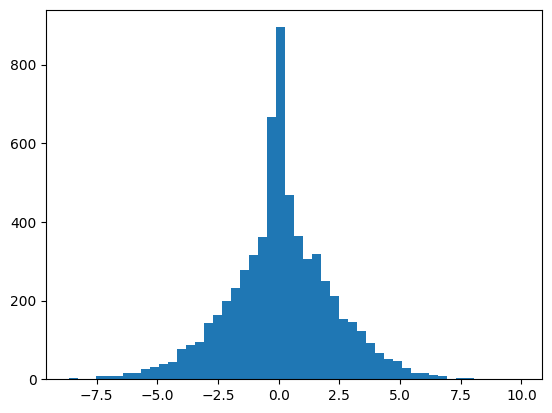

In [87]:
plt.hist(hpreact.view(-1).tolist(), 50)

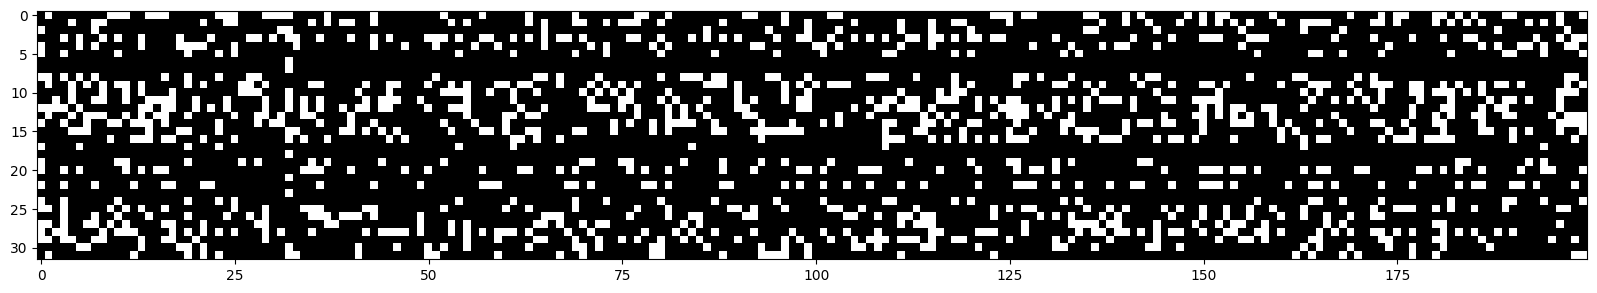

In [88]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

#fixing saturated tanh()
#post-activation values are very near 1 or -1, causing the gradient to not pass through the tanh layer
# because the derivative is (1 - tanh^2), extreme outputs caused by high values at initialization can cause "dead neurons"
# multiply weights and biases that feed into tanh() by a small scale factor

In [148]:
#calibrate the batch norm at the end of training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1

    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [149]:
@torch.no_grad()
def split_loss(split):

    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(loss.item())

split_loss('train')
split_loss('val')

2.071403741836548
2.113656997680664


In [20]:
#sample from the model:
g = torch.Generator().manual_seed(2147483647 + 10)


for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
kayah.
see.
med.
rylle.
emmastendraen.
adered.
eliah.
mikaelle.
elson.
anareelyn.
malaia.
nyshubergahimier.
kendreelynn.
nophork.
brence.
ryyah.
fael.
yula.
mysanyah.
